### Analisis Finanzas 
#### Segundo desafio
¬øLos clientes con pr√©stamos e hipotecas tienden a tener un saldo medio m√°s bajo o m√°s riesgo de incumplimiento? ¬øC√≥mo deber√≠amos ajustar nuestras ofertas y estrategias de gesti√≥n de riesgos en funci√≥n de estos hallazgos?

#### Librerias y m√°s

In [28]:
"""Librer√≠as que pueden ser necesarias"""

# Manejo de datos
import pandas as pd                 # An√°lisis y manipulaci√≥n de datos en tablas
import numpy as np                  # C√°lculos num√©ricos y matrices
import os                           # Gesti√≥n de rutas de archivos
import re                           # Expresiones regulares para b√∫squeda y manipulaci√≥n de texto

# Visualizaci√≥n de datos
import matplotlib.pyplot as plt     # Gr√°ficos b√°sicos en 2D
import seaborn as sns               # Gr√°ficos estad√≠sticos mejorados
import plotly.express as px         # Gr√°ficos interactivos simplificados
import plotly.graph_objects as go   # Control avanzado de gr√°ficos en Plotly
import plotly.io as pio             # Interfaz de entrada/salida de Plotly
import squarify                     # Visualizaci√≥n de diagramas de "treemap"

# Procesado y an√°lisis
from scipy import stats
from scipy.stats import chi2_contingency # Pruebas de hip√≥tesis y an√°lisis estad√≠stico
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")#ignorar advertencias

#Paleta de colores oficial
custom_palette = [ "#2CCED1", "#5F6F81", "#AABBC8", "#DCE3EA", "#2E2F36"]

#### Carga de datos

In [29]:
df = pd.read_csv('../Data/df_250519.csv')

#### Tabla relacion Prestamos e hipotecas
Se analiza si tiene prestamo, si tiene hipoteca, Saldo medio y tasa de incumplimiento

   Tiene pr√©stamo  Tiene hipoteca  Saldo medio  Tasa incumplimiento  \
0           False           False  1844.047228             0.008864   
1           False            True  1365.205982             0.013876   
2            True           False   801.467991             0.057395   
3            True            True   773.169967             0.026403   

   N√∫mero de clientes  
0                7559  
1                6486  
2                 906  
3                1212  


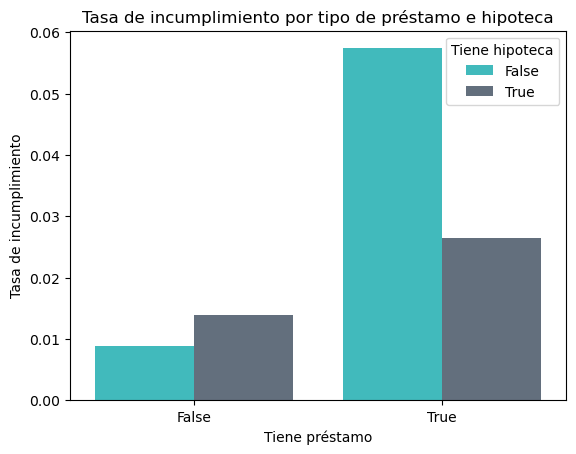

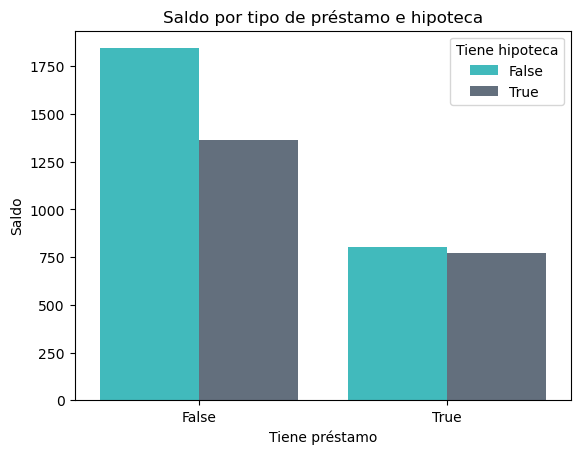

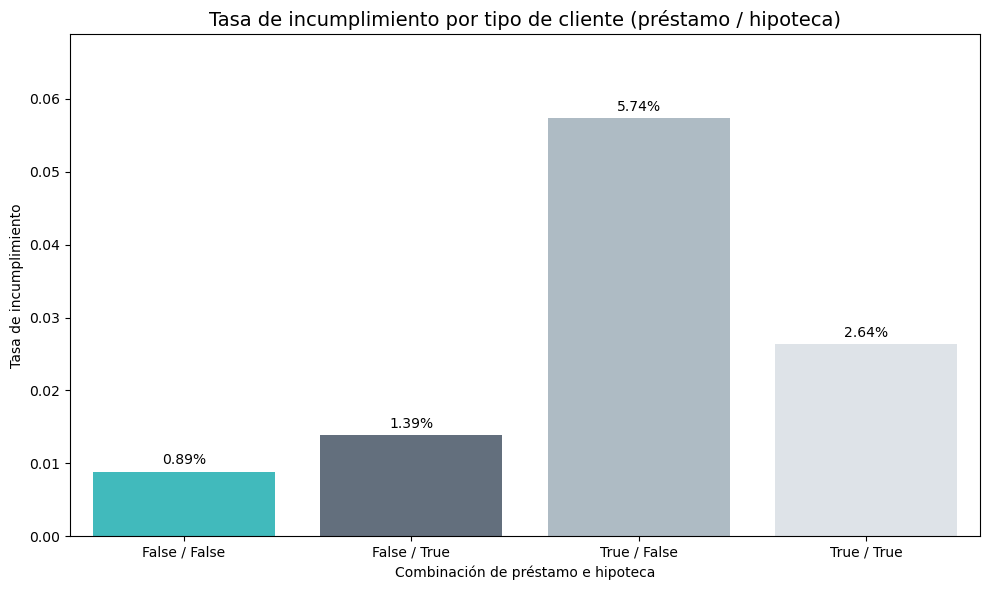

In [30]:
Tabla_agrupada = df.groupby(['loan', 'housing']).agg({'balance': 'mean','default': 'mean','id': 'count'}).reset_index()
Tabla_agrupada.columns = ['Tiene pr√©stamo', 'Tiene hipoteca', 'Saldo medio', 'Tasa incumplimiento', 'N√∫mero de clientes'] 
print(Tabla_agrupada)

'''Esteos graficos se puede cambiar de orden para mostrarlos de manera inversa 
prestamo como Hue y hipoteca como x'''

sns.barplot(data=Tabla_agrupada, x='Tiene pr√©stamo', y='Tasa incumplimiento', hue='Tiene hipoteca', palette=custom_palette)
plt.title("Tasa de incumplimiento por tipo de pr√©stamo e hipoteca")
plt.ylabel("Tasa de incumplimiento")
plt.show()

sns.barplot(data=Tabla_agrupada, x='Tiene pr√©stamo', y='Saldo medio', hue='Tiene hipoteca', palette=custom_palette)
plt.title("Saldo por tipo de pr√©stamo e hipoteca")
plt.ylabel("Saldo")
plt.show()

# Barras combinadas
plt.figure(figsize=(10,6))
sns.barplot(x='Grupo', y='Tasa incumplimiento', data=df_viz, palette= custom_palette)

plt.title('Tasa de incumplimiento por tipo de cliente (pr√©stamo / hipoteca)', fontsize=14)
plt.ylabel('Tasa de incumplimiento')
plt.xlabel('Combinaci√≥n de pr√©stamo e hipoteca')
plt.ylim(0, df_viz['Tasa incumplimiento'].max()*1.2)

for i, row in df_viz.iterrows():
    plt.text(i, row['Tasa incumplimiento'] + 0.001, f"{row['Tasa incumplimiento']:.2%}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

### Representaci√≥n gr√°fica del saldo promedio por tipo de cliente en funci√≥n de pr√©stamos

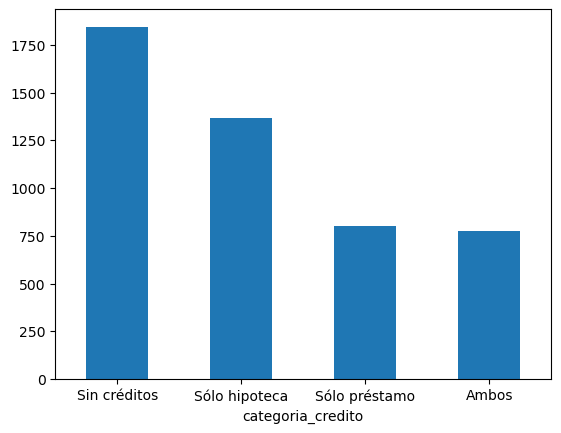

In [31]:
def categorize_credit(row):
    if not row['loan'] and not row['housing']:
        return 'Sin cr√©ditos'
    elif not row['loan'] and row['housing']:
        return 'S√≥lo hipoteca'
    elif row['loan'] and not row['housing']:
        return 'S√≥lo pr√©stamo'
    else:
        return 'Ambos'

df['categoria_credito'] = df.apply(categorize_credit, axis=1)

# Agrupar y calcular promedio de balance
balance_promedio = df.groupby('categoria_credito')['balance'].mean().reindex([
    'Sin cr√©ditos', 'S√≥lo hipoteca', 'S√≥lo pr√©stamo', 'Ambos'])

# Gr√°fica
balance_promedio.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

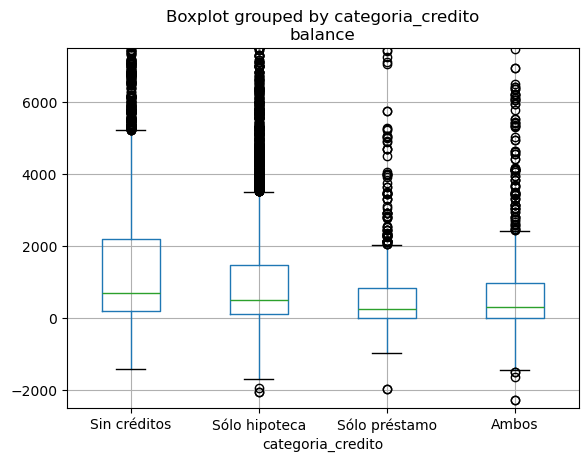

In [32]:
orden_categorias = ['Sin cr√©ditos', 'S√≥lo hipoteca', 'S√≥lo pr√©stamo', 'Ambos']
df['categoria_credito'] = pd.Categorical(df['categoria_credito'], categories=orden_categorias, ordered=True)

df.boxplot(column='balance', by='categoria_credito')
plt.ylim(-2500, 7500)
plt.show()

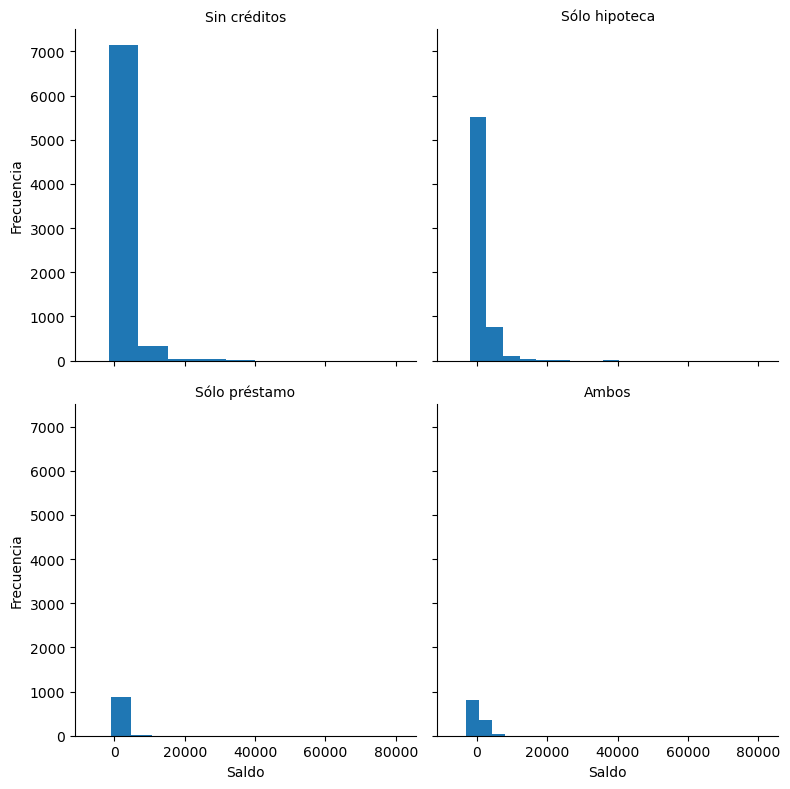

In [33]:
# Facetgrid con histogramas
g = sns.FacetGrid(df, col='categoria_credito', col_wrap=2, height=4, sharex=True, sharey=True)
g.map(plt.hist, 'balance', bins=10)

g.set_titles(col_template='{col_name}')
g.set_axis_labels('Saldo', 'Frecuencia')
plt.tight_layout()
plt.show()

### Razon de monomios
chances de incumplimiento al tener un prestamo o hipoteca
La raz√≥n de momios (odds ratio) se calcula as√≠:
odds ratio = odds de default en expuesto / odds de default en no expuestos.

donde :

odds de default en expuesto  = personas con inpago y con (prestamo, hipoteca) / personas sin inpago y con (prestamo, hipoteca)

odds de default en no expuestos = personas con inpago y sin (prestamo, hipoteca) / personas sin inpago y sin (prestamo, hipoteca)



#### Nota
use odds ratio en lugar de riesgo relativo pues tengo la intencion de hacer una regresion logistica si da tiempo

In [34]:
def odds_ratio(df, column_a, column_b):
    """Calcula la raz√≥n de probabilidades (odds ratio) entre dos grupos."""
    tabla_contingencia = pd.crosstab(df[column_a],df[column_b] )
    A= tabla_contingencia.iloc[1, 1] 
    B= tabla_contingencia.iloc[1, 0] 
    C= tabla_contingencia.iloc[0, 1]
    D= tabla_contingencia.iloc[0, 0]
    # Evitar divisiones por cero
    if B == 0 or D == 0:
        print("‚ö†Ô∏è Uno de los valores es cero, no se puede calcular la raz√≥n de momios.")
        return None
    odds_expuesto = A / B
    odds_no_expuesto = C / D
    odds_ratio = odds_expuesto /odds_no_expuesto
    print(f"üìä Tabla de contingencia entre '{column_a}' y '{column_b}':\n{tabla_contingencia}\n")
    print(f"odds_sin_{column_a}: {odds_expuesto}")
    print(f"odds_con_{column_a} : {odds_no_expuesto}")
    print(f"odds_ratio: {odds_ratio}")
    
# aplicar la funci√≥n a los datos
odds_ratio(df, 'loan', 'default')
odds_ratio(df, 'housing', 'default')


üìä Tabla de contingencia entre 'loan' y 'default':
default  False  True 
loan                 
False    13888    157
True      2034     84

odds_sin_loan: 0.04129793510324484
odds_con_loan : 0.011304723502304147
odds_ratio: 3.6531574695150595
üìä Tabla de contingencia entre 'housing' y 'default':
default  False  True 
housing              
False     8346    119
True      7576    122

odds_sin_housing: 0.016103484688489968
odds_con_housing : 0.014258327342439491
odds_ratio: 1.1294091026061956


### Calculo del intervalo de confianza
calculado al 95% 

In [35]:
def calcular_odds_ratio_ic(df, columna_a, columna_b, alpha=0.05):
    tabla = pd.crosstab(df[columna_a], df[columna_b])
    
    # use true/false para evitar errores y confusiones
    A = tabla.loc[True, True]
    B = tabla.loc[True, False]  
    C = tabla.loc[False, True]
    D = tabla.loc[False, False]  
    odds_expuesto = A / B
    odds_no_expuesto = C / D
    OR = odds_expuesto /odds_no_expuesto

    # Log(OR) y error est√°ndar
    log_or = np.log(OR) # logaritmo natural de la raz√≥n de momios
    se_log_or = np.sqrt(1/A + 1/B + 1/C + 1/D) # error est√°ndar del logaritmo de la raz√≥n de momios
    # Intervalo de confianza
    z = norm.ppf(1 - alpha / 2) # valor cr√≠tico para el nivel de confianza
    lower = np.exp(log_or - z * se_log_or) # intervalo inferior
    upper = np.exp(log_or + z * se_log_or) # intervalo superior

    print(f"üìä Odds Ratio entre '{columna_a}' y '{columna_b}': {OR:.4f}")
    print(f"üîí Intervalo de confianza {int((1-alpha)*100)}%: [{lower:.4f}, {upper:.4f}]")
    
    

# Aplicar la funci√≥n a los datos
calcular_odds_ratio_ic(df, 'loan', 'default')
calcular_odds_ratio_ic(df, 'housing', 'default')

üìä Odds Ratio entre 'loan' y 'default': 3.6532
üîí Intervalo de confianza 95%: [2.7915, 4.7808]
üìä Odds Ratio entre 'housing' y 'default': 1.1294
üîí Intervalo de confianza 95%: [0.8757, 1.4566]


### Chi cuadrado
comprobar la relaciond variables categoricas

In [36]:
# Funci√≥n para ejecutar Chi-cuadrado entre default y una variable categ√≥rica
def Funcion_Chi2(df, column):
    Tabla_contingencia = pd.crosstab(df[column], df['default'])
    chi2, p, dof, expected = chi2_contingency(Tabla_contingencia)
    print(f"\nTest Chi-cuadrado entre '{column}' y 'default'")
    print("Tabla de contingencia:\n", Tabla_contingencia)
    print(f"Chi2 = {chi2:.4f}, p-valor = {p:.4f}, grados de libertad = {dof}")
    if p < 0.05:
        print("‚ùóHay evidencia estad√≠stica de asociaci√≥n entre las variables.")
    else:
        print("‚úÖ No se detecta asociaci√≥n estad√≠sticamente significativa.")

# Aplicar a 'loan' y 'housing'
Funcion_Chi2(df, 'loan')
Funcion_Chi2(df, 'housing')


Test Chi-cuadrado entre 'loan' y 'default'
Tabla de contingencia:
 default  False  True 
loan                 
False    13888    157
True      2034     84
Chi2 = 99.7154, p-valor = 0.0000, grados de libertad = 1
‚ùóHay evidencia estad√≠stica de asociaci√≥n entre las variables.

Test Chi-cuadrado entre 'housing' y 'default'
Tabla de contingencia:
 default  False  True 
housing              
False     8346    119
True      7576    122
Chi2 = 0.7622, p-valor = 0.3826, grados de libertad = 1
‚úÖ No se detecta asociaci√≥n estad√≠sticamente significativa.


# KPIs

- saldo medio gral
- saldo medio por decil
- % clientes por tasa de riesgo
- % clientes con hipoteca
- % clientes con pr√©stamo
- % clientes con hipoteca + pr√©stamo
- tasa contrataci√≥n dep√≥sito
- tasa incumplimiento
- probabilidad de incumplimiento global

In [37]:
# Saldo medio general
saldo_medio = df['balance'].mean()
print(round((saldo_medio/1000),1), "k‚Ç¨")

1.5 k‚Ç¨


In [38]:
# % de clientes con hipoteca
con_hipoteca = df['housing'].value_counts().get(True)
total = len(df['housing'])

hipoteca_pct = 100 * con_hipoteca / total
print(f"{hipoteca_pct:.2f}%")

47.63%


In [39]:
# % de clientes con pr√©stamo
con_prestamo = df['loan'].value_counts().get(True)
total = len(df['loan'])

prestamo_pct = 100 * con_prestamo / total
print(f"{prestamo_pct:.2f}%")

13.10%


In [40]:
# % de clientes con ambos
con_ambos = len(df[df['loan'] & df['housing']])
total = len(df)

ambos_pct = 100 * con_ambos / total
print(f"{ambos_pct:.2f}%")

7.50%


In [41]:
# % contratacion deposito
contratan = df['deposit'].value_counts().get(True)
total = len(df['deposit'])

deposito_pct = 100 * contratan / total
print(f"{deposito_pct:.2f}%")

47.71%


In [42]:
# % de incumplimiento global
pd_global = df['default'].mean()
print("PD global =", (pd_global*100).round(2), "%")

PD global = 1.49 %


In [43]:
# Crear deciles y calcular m√©tricas de riesgo
df['balance_decile'] = pd.qcut(df['balance'], q=10, labels=False)
default_rates = (
    df.groupby('balance_decile')['default']
    .agg(['mean', 'count'])
    .reset_index()
    .rename(columns={'mean': 'default', 'count': 'clientes'})
)
default_rates['balance_decile'] += 1
default_rates['default'] = default_rates['default'].round(4)
default_rates['indice_riesgo'] = (default_rates['default'] / pd_global).round(2)

# Calcular porcentaje de clientes por decil
clientes_totales = len(df)
default_rates['porcentaje_clientes'] = (default_rates['clientes'] / clientes_totales * 100).round(2)

# Clasificar nivel de riesgo
def categorize_risk(rate):
    return (
        'Muy alto' if rate > 0.10 else
        'Alto'     if rate > 0.05 else
        'Moderado' if rate > 0.02 else
        'Bajo'
    )

default_rates['risk_level'] = default_rates['default'].apply(categorize_risk)

# Porcentaje de clientes por categor√≠a de riesgo
porcentaje_riesgo = (
    default_rates.groupby('risk_level')['porcentaje_clientes']
    .sum()
    .reindex(['Muy alto', 'Alto', 'Moderado', 'Bajo'])
    .reset_index()
)
porcentaje_riesgo['porcentaje_clientes'] = porcentaje_riesgo['porcentaje_clientes'].fillna(0).astype(int)
porcentaje_riesgo

risk_level  porcentaje_clientes
0   Muy alto                    0
1       Alto                   13
2   Moderado                    6
3       Bajo                   79